[long-term] Study the funnels’ high-variance regions & what causes those features; <br>
-> By examining the correlations between MI(Te) and [RT instability] MI(ρ_gas) and potentially MI(Pg) and [large-scale mag interchange] MI(B) to see if MI(Te) has a higher correlation with one of the two components -> tell us which one is the more dominant mechanism <br>
$\space \space$-->  assume those mechanisms act on every part of the accretion flow and funnel initially ("symmetry"), study one side (say, left side) of the accretion flow and funnel; "chunks" of B in contrast with grid values of ρ_gas and Pg to represent large scale and local scale!

Numerical simulation method:
Correlation matrix: Te of rho, Pg, Pmag, so 3 matrices in total for each set
How to do a multi-variable correlation analysis based on correlation matrices? 

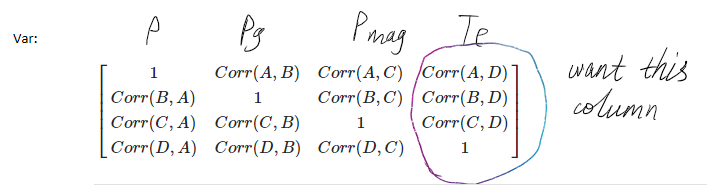

In [ ]:
from toolz import valmap

import h5py
import pyharm

import matplotlib.pyplot as plt
import numpy as np
from numpy import ma

from scipy import signal

In [ ]:
i0 = 5010 # initial  frame
i1 = 5061 # 1 + last frame

fmt = 'torus.out0.{:05d}.h5'

qualities = ['RHO', 'Pg', 'bsq', 'beta', 'Theta', 'Thetae']

In [ ]:
# some constants
cl = 29979245800.0 # speed of light in cgs
mp = 1.67262171e-24
kb = 1.3806505e-16
mu = 1.

In [ ]:
def fname(i, src): # closure on `src` and `fmt`
    return (src+fmt).format(i)

In [ ]:
src_save_ma = '/home/u12/limengjiang/GRMHD/variances/MAD'
src_save_sa = '/home/u12/limengjiang/GRMHD/variances/SANE'

In [ ]:
def get_dumps(i0, i1, src, step=1):
    dumps = {}
    for i in range(i0, i1, step):
        dumps[str(i)] = pyharm.load_dump(fname(i, src))
    return dumps

## Read in data

### MAD

In [ ]:
# Rh=1.
path_ma_Rh1 = src_save_ma + '/Rh1'
dumps_ma_Rh1 = get_dumps(i0, i1, path_ma_Rh1)

In [ ]:
# Rh=160.
path_ma_Rh160 = src_save_ma + '/Rh160'
dumps_ma_Rh160 = get_dumps(i0, i1, path_ma_Rh160)

### SANE

In [ ]:
# Rh=1.
path_sa_Rh1 = src_save_sa + '/Rh1'
dumps_sa_Rh1 = get_dumps(i0, i1, path_sa_Rh1)

In [ ]:
# Rh=160.
path_ma_Rh160 = src_save_sa + '/Rh160'
dumps_sa_Rh160 = get_dumps(i0, i1, path_sa_Rh160)

# Correlation

### MAD

Convolve Pmag <br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html <br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

### SANE

Convolve Pmag